In [1]:
import pandas as pd

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# RQ3: Did the sustainability-aware explanation types within each domain differ in terms of (1) perceived sustainability-focused dimensions and in terms of (2) perceived explanation goals? 

## Sustainability-focused dimensions

In [95]:
import pandas as pd
from scipy.stats import shapiro, kruskal, mannwhitneyu
import itertools
from pathlib import Path

BASE_DIR = Path.home() / "Desktop" / "Sustainable-Aware-Exp" / "Backpacks"

output_path = BASE_DIR / "merged_all_backpacks_treatment.csv"
df = pd.read_csv(output_path)


cat_cols = [
    'Group',
    'SustainabilityInclination/Influence',   #Persuasiveness
    'SustainabilityAwareness/Effectiveness', #Effectiveness
    'SustainabilityImportance',              #Importance
]

likert_map = {
    'Strongly Disagree': 1,
    'Disagree'         : 2,
    'Neutral'          : 3,
    'Agree'            : 4,
    'Strongly Agree'   : 5
}

for col in cat_cols[1:]:
    print(f"\n=== {col} ===")
    ct = pd.crosstab(df[col], df['Group'])
    print("\nCounts:\n", ct)
    print("\n% within each level:\n", (ct.div(ct.sum(axis=1),axis=0)*100).round(1))

    positive = ct.loc[['Agree','Strongly Agree']].sum()
    print("\nSum of Agree + Strongly Agree by Group:\n", positive)

    
    code_col = f"{col}_code"
    df[code_col] = df[col].map(likert_map)
    sub = df.dropna(subset=[code_col, 'Group'])
    
    # ==== Shapiro–Wilk per group ====
    print("\nShapiro–Wilk normality test per Group:")
    normal_pvals = []
    for g in sub['Group'].unique():
        vals = sub.loc[sub['Group']==g, code_col]
        w_stat, p_norm = shapiro(vals)
        normal_pvals.append(p_norm)
        print(f"  {g:<20} W={w_stat:.3f}, p={p_norm:.3f}")
    if all(p > 0.05 for p in normal_pvals):
        print("  → All groups look roughly normal (p > .05)")
    else:
        print("  → At least one group is non‑normal (p ≤ .05), using Kruskal–Wallis")
   
    
    # ==== Kruskal–Wallis ====
    groups = sub['Group'].unique()
    samples = [sub.loc[sub['Group']==g, code_col] for g in groups]
    h_stat, p_val = kruskal(*samples)
    print(f"\nKruskal–Wallis H = {h_stat:.2f}, p = {p_val:.3f}")
    
    # pairwise follow‑ups as before…
    if p_val < 0.05:
        m = len(groups)*(len(groups)-1)/2
        alpha_bonf = 0.05 / m
        print(f" Pairwise Mann–Whitney U tests (α′={alpha_bonf:.4f}):")
        for g1, g2 in itertools.combinations(groups, 2):
            a = sub.loc[sub['Group']==g1, code_col]
            b = sub.loc[sub['Group']==g2, code_col]
            u, p_u = mannwhitneyu(a, b, alternative='two-sided')
            p_adj = min(p_u * m, 1.0)
            sig = "yes" if p_adj < 0.05 else "no"
            print(f"  {g1} vs {g2}: U={u}, raw p={p_u:.3f}, adj p={p_adj:.3f} → sig? {sig}")
    print("-"*60)



=== SustainabilityInclination/Influence ===

Counts:
 Group                                ExternalInformation  Framing  Salience  Simplification
SustainabilityInclination/Influence                                                        
Agree                                                 13       14        13               7
Disagree                                               1        3         2               8
Neutral                                                5        4         4               4
Strongly Agree                                         8        8         8               9
Strongly Disagree                                      3        1         3               2

% within each level:
 Group                                ExternalInformation  Framing  Salience  Simplification
SustainabilityInclination/Influence                                                        
Agree                                               27.7     29.8      27.7            14.9
Di

## Figure 3

/var/folders/x5/4x0pvs_971l5vwmtfgh5snfr0000gn/T/ipykernel_6579/4120136295.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Group', 'Level'])
/var/folders/x5/4x0pvs_971l5vwmtfgh5snfr0000gn/T/ipykernel_6579/4120136295.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Group', 'Level'])
/var/folders/x5/4x0pvs_971l5vwmtfgh5snfr0000gn/T/ipykernel_6579/4120136295.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

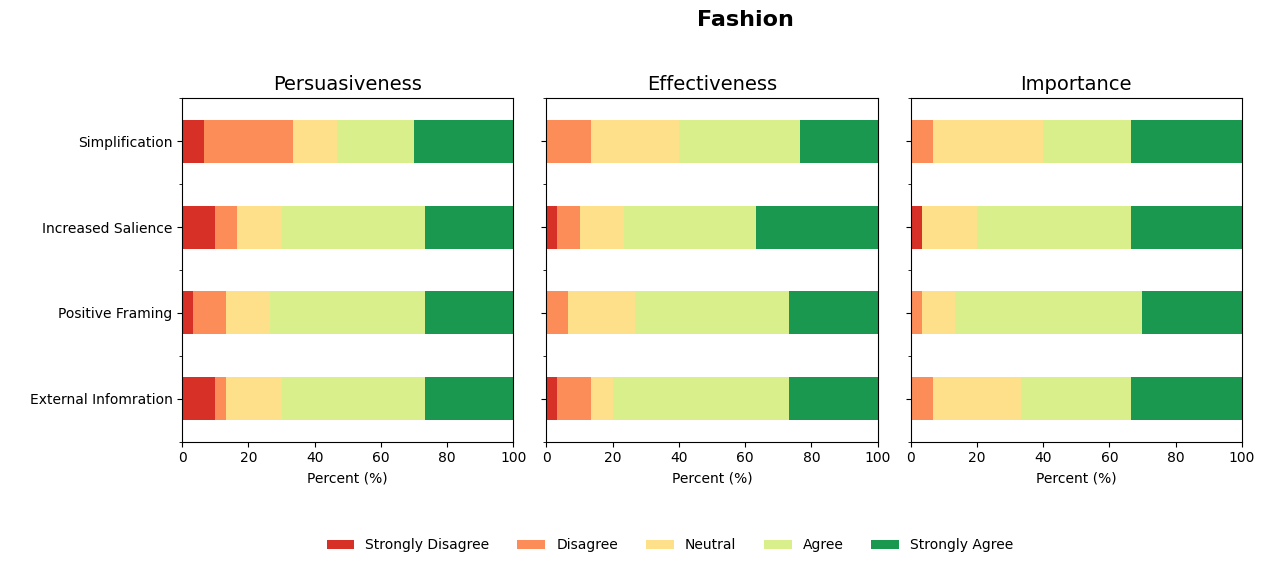

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path.home() / "Desktop" / "Sustainable-Aware-Exp" / "Backpacks"
df = pd.read_csv(BASE_DIR / "merged_all_backpacks_treatment.csv")

questions = [
    'SustainabilityInclination/Influence',  
    'SustainabilityAwareness/Effectiveness',  
    'SustainabilityImportance',  
]

likert_order = [
    'Strongly Disagree', 'Disagree', 'Neutral',
    'Agree', 'Strongly Agree'
]

colors = ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#1a9850"]
melted = df.melt(
    id_vars=['Group'], 
    value_vars=questions,
    var_name='Question', 
    value_name='Level'
)
melted['Level'] = pd.Categorical(
    melted['Level'],
    categories=likert_order,
    ordered=True
)


new_labels = [
    "External Infomration",
    "Positive Framing",
    "Increased Salience",
    "Simplification",
]

titles = {
    'SustainabilityInclination/Influence': "Persuasiveness",
    'SustainabilityAwareness/Effectiveness': "Effectiveness",
    'SustainabilityImportance': "Importance"
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, q in zip(axes, questions):
    ct = (
        melted[melted['Question'] == q]
        .groupby(['Group', 'Level'])
        .size()
        .unstack(fill_value=0)
    )
    pct = ct.div(ct.sum(axis=1), axis=0) * 100
    
    pct.plot(
        kind='barh',
        stacked=True,
        color=colors,
        ax=ax,
        legend=False  
    )
    ax.set_title(titles[q], fontsize=14)
    ax.set_xlabel("Percent (%)")
    ax.set_xlim(0, 100)
    ax.set_yticklabels(new_labels)
    ax.set_ylabel(" ")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    title=" ", 
    bbox_to_anchor=(0.45, -0.01), 
    ncol=5, 
    loc='upper center',
    frameon=False
)

fig.suptitle("Fashion", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()


In [13]:
import pandas as pd
from scipy.stats import shapiro, kruskal, mannwhitneyu
import itertools
from pathlib import Path

BASE_DIR = Path.home() / "Desktop" / "Sustainable-Aware-Exp" / "Backpacks"

output_path = BASE_DIR / "merged_all_backpacks_treatment.csv"
df = pd.read_csv(output_path)


cat_cols = [
    'Group',
    'Efectiveness',
    'Transparency', 
    'Persuadiveness', 
    'Scrutability', 
    'Efficiency',
    'Trust',
    'Satisfaction'
]

likert_map = {
    'Strongly Disagree': 1,
    'Disagree'         : 2,
    'Neutral'          : 3,
    'Agree'            : 4,
    'Strongly Agree'   : 5
}

for col in cat_cols[1:]:
    print(f"\n=== {col} ===")
    ct = pd.crosstab(df[col], df['Group'])
    print("\nCounts:\n", ct)
    print("\n% within each level:\n", (ct.div(ct.sum(axis=1),axis=0)*100).round(1))

    positive = ct.loc[['Agree','Strongly Agree']].sum()
    print("\nSum of Agree + Strongly Agree by Group:\n", positive)

    
    code_col = f"{col}_code"
    df[code_col] = df[col].map(likert_map)
    sub = df.dropna(subset=[code_col, 'Group'])
    
    # ====  Shapiro–Wilk per group ====
    print("\nShapiro–Wilk normality test per Group:")
    normal_pvals = []
    for g in sub['Group'].unique():
        vals = sub.loc[sub['Group']==g, code_col]
        w_stat, p_norm = shapiro(vals)
        normal_pvals.append(p_norm)
        print(f"  {g:<20} W={w_stat:.3f}, p={p_norm:.3f}")
    if all(p > 0.05 for p in normal_pvals):
        print("  → All groups look roughly normal (p > .05)")
    else:
        print("  → At least one group is non‑normal (p ≤ .05), using Kruskal–Wallis")
   
    
    # ==== Kruskal–Wallis ====
    groups = sub['Group'].unique()
    samples = [sub.loc[sub['Group']==g, code_col] for g in groups]
    h_stat, p_val = kruskal(*samples)
    print(f"\nKruskal–Wallis H = {h_stat:.2f}, p = {p_val:.3f}")
    
    # pairwise follow‑ups 
    if p_val < 0.05:
        m = len(groups)*(len(groups)-1)/2
        alpha_bonf = 0.05 / m
        print(f" Pairwise Mann–Whitney U tests (α′={alpha_bonf:.4f}):")
        for g1, g2 in itertools.combinations(groups, 2):
            a = sub.loc[sub['Group']==g1, code_col]
            b = sub.loc[sub['Group']==g2, code_col]
            u, p_u = mannwhitneyu(a, b, alternative='two-sided')
            p_adj = min(p_u * m, 1.0)
            sig = "yes" if p_adj < 0.05 else "no"
            print(f"  {g1} vs {g2}: U={u}, raw p={p_u:.3f}, adj p={p_adj:.3f} → sig? {sig}")
    print("-"*60)



=== Efectiveness ===

Counts:
 Group              ExternalInformation  Framing  Salience  Simplification
Efectiveness                                                             
Agree                                8       13         7              10
Disagree                             5        1         2               2
Neutral                              6        1         1               2
Strongly Agree                       6        6         6               5
Strongly Disagree                    1        1         1               1

% within each level:
 Group              ExternalInformation  Framing  Salience  Simplification
Efectiveness                                                             
Agree                             21.1     34.2      18.4            26.3
Disagree                          50.0     10.0      20.0            20.0
Neutral                           60.0     10.0      10.0            20.0
Strongly Agree                    26.1     26.1      26.1

In [12]:
num_map = {
  'Strongly Disagree': 1,
  'Disagree':          2,
  'Neutral':           3,
  'Agree':             4,
  'Strongly Agree':    5
}
df['PersuadivenessnScore'] = df['Persuadiveness'].map(num_map)

# Compute group means
df.groupby('Group')['PersuadivenessnScore'].mean()

means = df.groupby('Group')['PersuadivenessnScore'].mean()
print(means.loc[['ExternalInformation','Simplification']])


Group
ExternalInformation    3.600000
Simplification         3.866667
Name: PersuadivenessnScore, dtype: float64
